In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform

env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
jax.config.update("jax_enable_x64", True)
sys.path.append('../synax/')

import synax
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

2024-07-08 14:11:02.020013: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


## read data

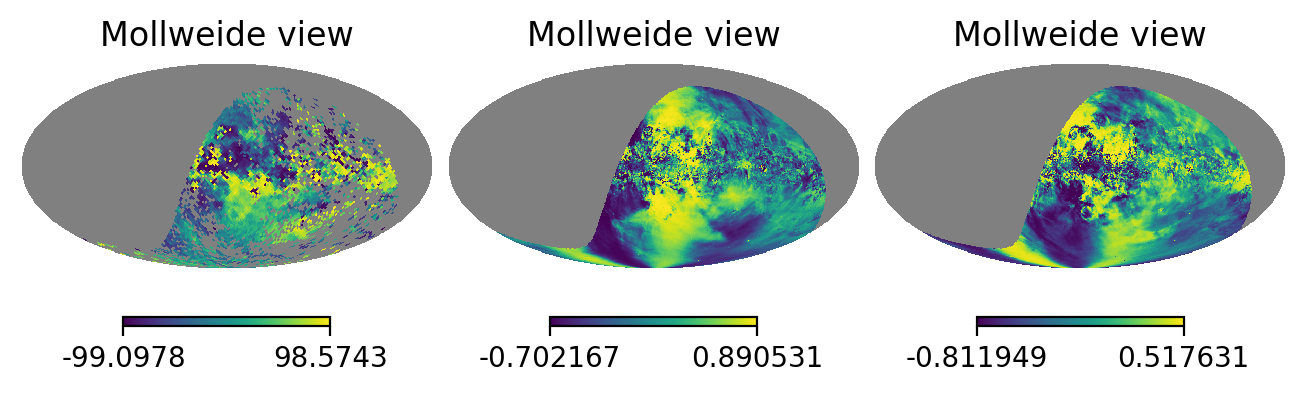

In [3]:
from astropy.io import fits
plt.figure(dpi=200)

fits_image_filename = 'rm.fits'

data_rm = hp.read_map(fits_image_filename)

data_rm = hp.reorder(data_rm,r2n=True)

#data = data.reshape((-1,16)).mean(axis=-1)

#data = hp.reorder(data,n2r=True)
index_rm = data_rm>-1e10
data_rm[~index_rm] = np.nan
hp.mollview(data_rm,norm='hist',sub=(1,3,1),nest=True)

fits_image_filename = 'spass_dr1_1902_healpix_Tb.q.fits'

data_q = hp.read_map(fits_image_filename)
data_q = hp.reorder(data_q,r2n=True)
data_q = data_q.reshape((-1,64)).mean(axis=-1)

index_qu = data_q>-1e10
data_q[~index_qu] = np.nan
hp.mollview(data_q,norm='hist',sub=(1,3,2),nest=True)

fits_image_filename = 'spass_dr1_1902_healpix_Tb.u.fits'

data_u = hp.read_map(fits_image_filename)
data_u = hp.reorder(data_u,r2n=True)
data_u = data_u.reshape((-1,64)).mean(axis=-1)


data_u[~index_qu] = np.nan
hp.mollview(data_u,norm='hist',sub=(1,3,3),nest=True)
data_u = jnp.array(data_u)
data_q = jnp.array(data_q)
data_rm = jnp.array(data_rm)

In [4]:
(data_u.shape[0]/data_rm.shape[0])**0.5

4.0

In [5]:
hp.npix2nside(data_q.shape[0])

128

## obtain locations

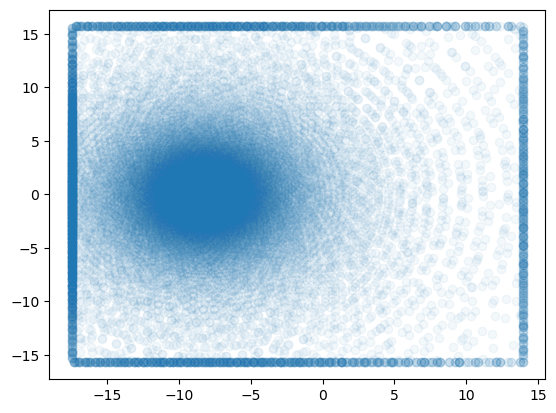

In [6]:
nside = 128
obtain_vmap = jax.vmap(lambda theta,phi:synax.obtain_positions(theta,phi,num_int_points=128))
n_pixs = np.arange(0,12*nside**2)
theta,phi = hp.pix2ang(nside,n_pixs,nest=True)
poss,dls,nhats = obtain_vmap(theta,phi)
nhats.shape
plt.scatter(poss[::10,0,100],poss[::10,1,100],alpha=0.05)

In [267]:
nx,ny,nz = 256,256,64

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(256, 256, 64)

In [268]:
dtype = np.float64  # 64-bit floating point

# Read the binary file
tereg = np.fromfile('../../SyncEmiss/tereg.bin', dtype=dtype).reshape((256,256,64))/100#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))
#ternd = np.fromfile('../../SyncEmiss/ternd.bin', dtype=dtype).reshape((256,256,64))*0#.reshape((64,4,64,4,16,4)).mean(axis = (1,3,5))

breg = np.fromfile('../../SyncEmiss/breg.bin', dtype=dtype).reshape((256,256,64,3)).reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))
brnd = np.fromfile('../../SyncEmiss/brnd.bin', dtype=dtype).reshape((256,256,64,3)).reshape((64,4,64,4,16,4,3)).mean(axis = (1,3,5))

B_field = jnp.ones_like(breg)*6e-6*jnp.array([0.5,-0.5,0.5])
tereg[tereg>0.002] = 0.
#B_field = jnp.array(breg+brnd)

#interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,B_field[...,0],method='linear',extrap=True))
#Bx_interp = interp_3d(poss)

#interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,B_field[...,1],method='linear',extrap=True))
#By_interp = interp_3d(poss)

#interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,B_field[...,2],method='linear',extrap=True))
#Bz_interp = interp_3d(poss)


interp_TE_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,TE_field,method='linear',extrap=True))

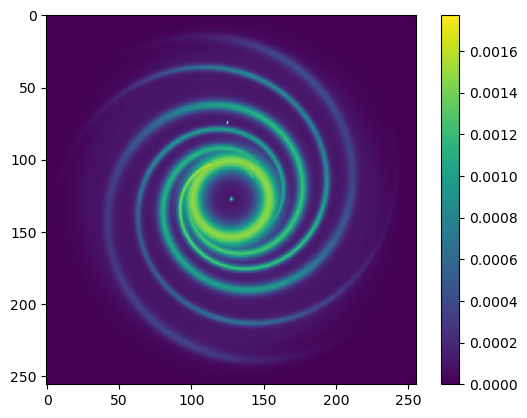

In [269]:
TE_field = tereg

TE_field_interp = interp_TE_3d(poss)
plt.imshow(tereg[:,:,32])
plt.colorbar()

In [270]:
#const
q_converter = 1/(4*np.pi*const.epsilon_0)**0.5

B_converter = (4*np.pi/const.mu_0)**0.5

freq_irrelavent_const = (const.e*q_converter)**3/(const.electron_mass**2*const.speed_of_light**4)/(2*np.pi)*1e6*1e-4*B_converter*1e19*3.08 # moves 1/cm^3 = 1e6 1/m^3 1 gauss = 1e-4 tesla 1 kpc = 3.08e19 m here.

freq_irrelavent_const

810407283.1937842

In [271]:
C_earth = synax.C_page(-8.3,0,0.006)
C_field = synax.C_page_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))*6.4e1/C_earth
#C_field = synax.C_uni_vmap(coords[0].reshape(-1),coords[1].reshape(-1),coords[2].reshape(-1))
C_field = C_field.reshape((nx,ny,nz))

interp_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,C_field,method='linear',extrap=True))

C_field_interp = interp_3d(poss)

In [272]:
freq = 2.3
sinb = nhats[...,2]
cosb = jnp.sqrt(1-sinb**2)
cosl = nhats[...,0]/cosb
sinl = nhats[...,1]/cosb

@jax.jit
def calc_pol(B_field):
    interp_B_3d = jax.vmap(lambda pos: interpax.interp3d(pos[0],pos[1],pos[2],xs,ys,zs,B_field,method='linear',extrap=True))
    B_field_interp = interp_B_3d(poss)
    B_los = -1*((nhats[:,jnp.newaxis,:]*B_field_interp)).sum(axis=-1)
    phis = freq_irrelavent_const*TE_field_interp*B_los
    
    

    Bz = B_field_interp[...,2]
    By = B_field_interp[...,1]
    Bx = B_field_interp[...,0]
    tanchi0 = (Bz*cosb[:,jnp.newaxis]-sinb[:,jnp.newaxis]*(cosl[:,jnp.newaxis]*Bx+By*sinl[:,jnp.newaxis]))/(Bx*sinl[:,jnp.newaxis]-By*cosl[:,jnp.newaxis])
    chi0 = jnp.arctan(tanchi0)
    
    phi_int = jnp.cumsum(phis,axis=1)*dls[:,jnp.newaxis]
    fd = phi_int*const.c**2/(freq**2*1e18)
    fd_q = jnp.cos(2*fd+2*chi0)
    fd_u = jnp.sin(2*fd+2*chi0)
    
    B_field_square = (B_field_interp**2).sum(axis=-1)

    B_trans = (B_field_square-B_los**2)**0.5
    emiss = synax.sync_emiss_P(freq,B_trans,C_field_interp,spectral_index=3.)
    Sync_Q_int = (emiss*fd_q).sum(axis=-1)*dls
    Sync_U_int = (emiss*fd_u).sum(axis=-1)*dls
    return phi_int[:,-1],Sync_Q_int,Sync_U_int
    

In [273]:
nx,ny,nz = 64,64,16

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(64, 64, 16)

In [274]:
%%time
rm,Sync_Q,Sync_U = calc_pol(B_field)

CPU times: user 11.3 s, sys: 1.81 s, total: 13.1 s
Wall time: 13.2 s


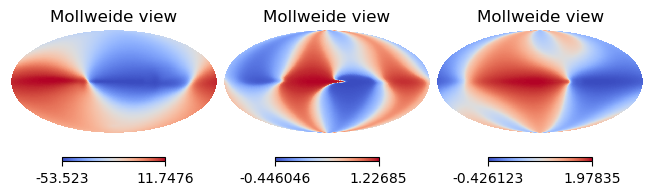

In [275]:
hp.mollview(rm,norm='hist',cmap='coolwarm',nest=True,sub=(1,3,1))
hp.mollview(Sync_Q,norm='hist',cmap='coolwarm',nest=True,sub=(1,3,2))
hp.mollview(Sync_U,norm='hist',cmap='coolwarm',nest=True,sub=(1,3,3))

In [276]:
@jax.jit
def loss(B_field):
    rm,Sync_Q,Sync_U = calc_pol(B_field)
    rm = rm.reshape((-1,16)).mean(axis=-1)
    loss_rm = jnp.mean((rm[index_rm] - data_rm[index_rm])**2)/jnp.var(rm[index_rm])
    loss_q = jnp.mean((Sync_Q[index_qu] - data_q[index_qu])**2)/jnp.var(data_q[index_qu])
    loss_u = jnp.mean((Sync_U[index_qu] - data_u[index_qu])**2)/jnp.var(data_u[index_qu])
    return loss_q+loss_u+loss_rm

In [277]:
%%time
loss(B_field)

CPU times: user 8.02 s, sys: 3.27 s, total: 11.3 s
Wall time: 9.07 s


Array(265.75857192, dtype=float64)

In [278]:
calc_grad = jax.value_and_grad(loss)


In [279]:
%%time
value,grad = calc_grad(B_field)
B_mask = jnp.where(grad==0.0)

CPU times: user 9.46 s, sys: 3.32 s, total: 12.8 s
Wall time: 10.5 s


In [281]:
from tqdm import tqdm
import optax

B_opt = B_field
#solver = optax.yogi(1e-8)
solver = optax.adam(learning_rate=1e-6)
opt_state = solver.init(B_opt)
loss = []
#mask = np.ones((64,64,16))
#mask[(coords[0]**2+coords[1]**2+)>400]=0.
#mask = jnp.array(mask)[:,:,:,jnp.newaxis]
#mask = C_field/C_field.max()
#B_opt = B_opt*mask

progress_bar = tqdm(range(1000))
for i in progress_bar:
    value,grad = calc_grad(B_opt)
    #grad.at[jnp.abs(grad)>1e-6].set(1e-6)
    grad = jnp.nan_to_num(grad, nan=1e-3)
    loss.append(value)
    updates, opt_state = solver.update(grad, opt_state, B_opt)
    B_opt = optax.apply_updates(B_opt, updates)
    #B_opt = B_opt*mask
    #B_opt = jnp.where(B_opt < 0., 1e-10, B_opt)
    info = { 'loss': loss[-1]}
    
    # Update the postfix with the current info
    progress_bar.set_postfix(info)

 17%|█▋        | 168/1000 [01:09<05:46,  2.40it/s, loss=1.8279838758412277]


KeyboardInterrupt: 

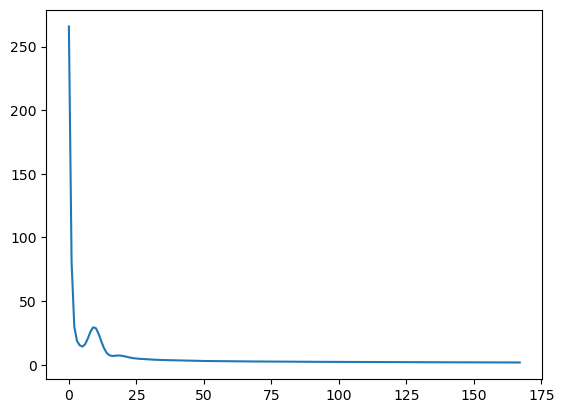

In [282]:
plt.plot(loss)

In [283]:
rm,Sync_Q,Sync_U = calc_pol(B_opt)
rm = rm.reshape((-1,16)).mean(axis=-1)
rm = np.array(rm)
Sync_Q = np.array(Sync_Q)
Sync_U = np.array(Sync_U)
rm[~index_rm] = np.nan
Sync_Q[~index_qu] = np.nan
Sync_U[~index_qu] = np.nan

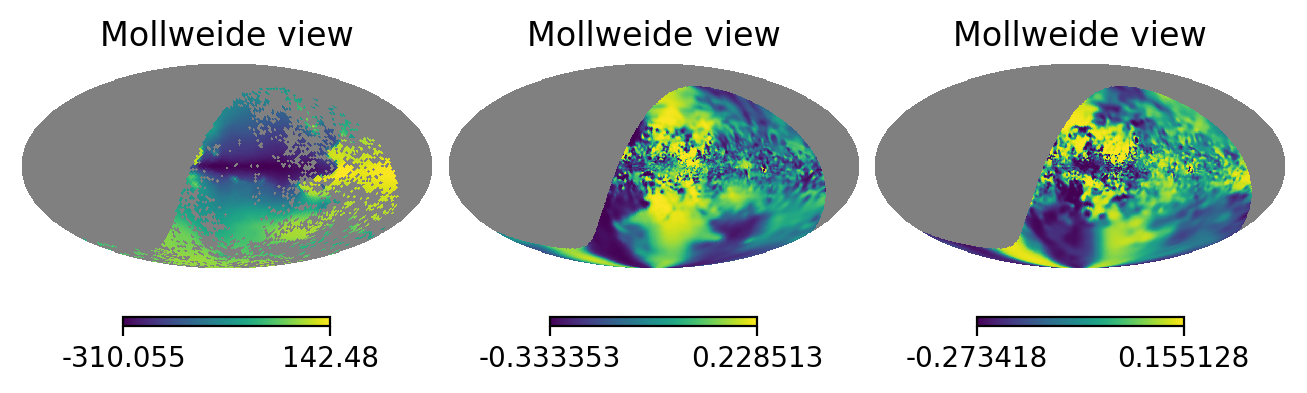

In [284]:
plt.figure(dpi=200)
hp.mollview(rm,norm='hist',nest=True,sub=(1,3,1))
hp.mollview(Sync_Q,norm='hist',nest=True,sub=(1,3,2))
hp.mollview(Sync_U,norm='hist',nest=True,sub=(1,3,3))

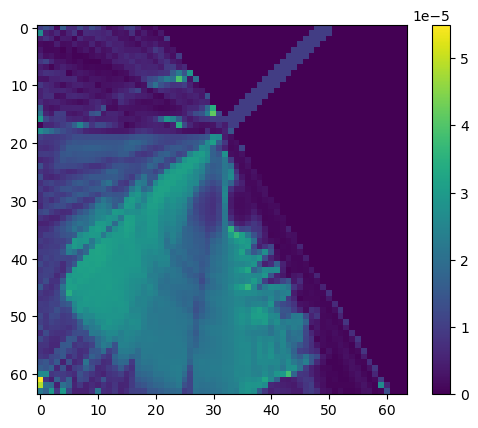

In [285]:
B_opt = B_opt.at[B_mask].set(0.0)
B_mag = jnp.sqrt((B_opt**2).sum(axis=-1))
plt.imshow((B_mag[:,:,8]))
plt.colorbar()

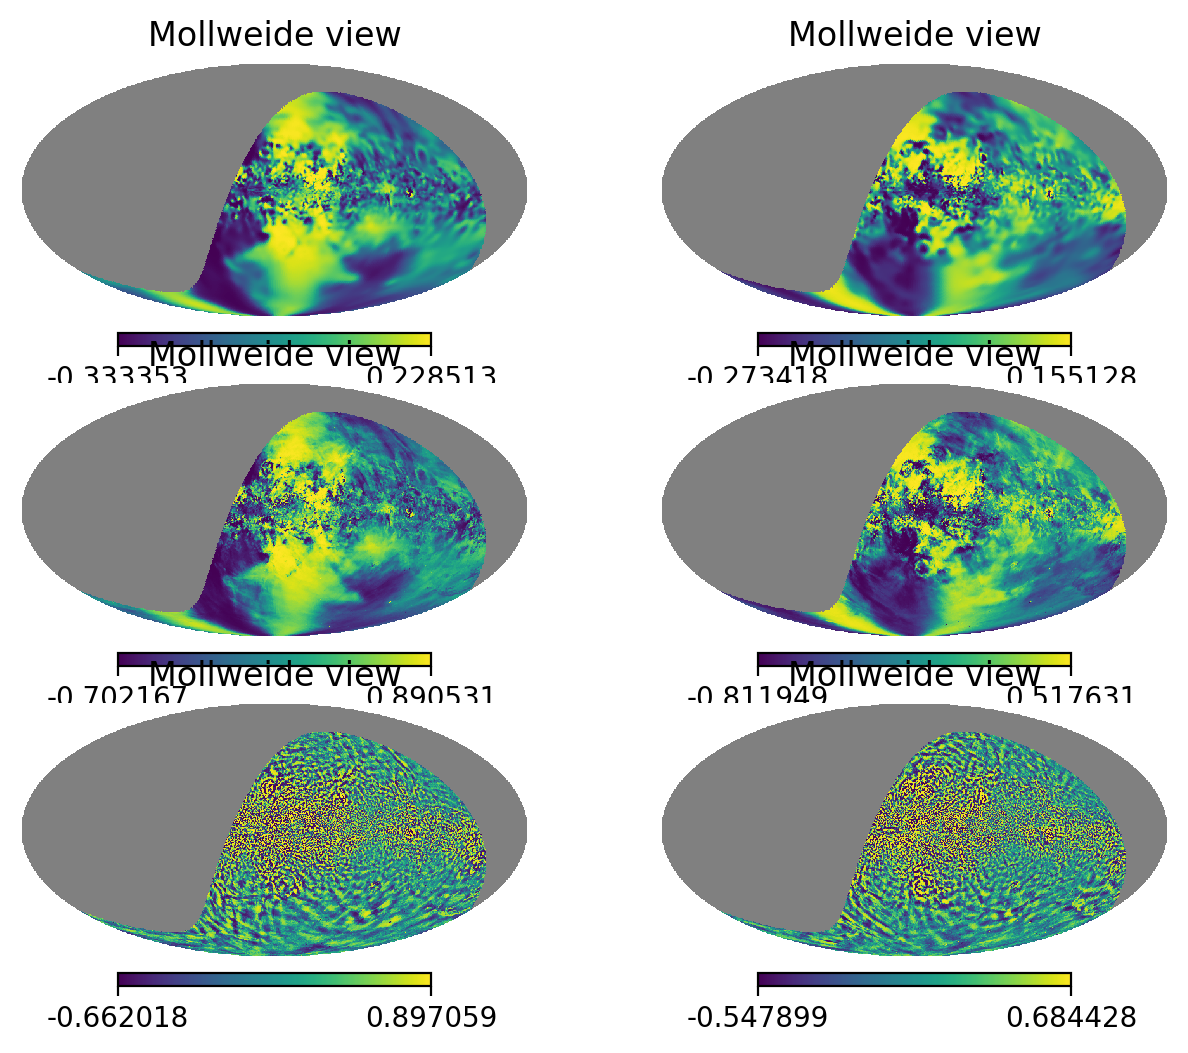

In [286]:
plt.figure(dpi=200)

hp.mollview(Sync_Q,norm='hist',nest=True,sub=(3,2,1))
hp.mollview(Sync_U,norm='hist',nest=True,sub=(3,2,2))

hp.mollview(data_q,norm='hist',nest=True,sub=(3,2,3))
hp.mollview(data_u,norm='hist',nest=True,sub=(3,2,4))

hp.mollview(Sync_Q-data_q,norm='hist',nest=True,sub=(3,2,5))
hp.mollview(Sync_U-data_u,norm='hist',nest=True,sub=(3,2,6))